# Higgs Boson Particle Classification

The ATLAS experiments at CERN utilize the Large Hadron Collider to produce Higgs boson particles for the purpose of studying their nature. However, these particles are exceedingly rare, making it essential to develop powerful machine learning algorithms to detect them. 

In this project, I will be utilizing machine learning algorithms from the RAPIDS framework to classify between Higgs boson and background processes. The dataset is vast, and handling large datasets with millions of rows and columns can be challenging for Pandas. Fortunately, RAPIDS provides the cuDF library for data preprocessing and analysis. I will be using cuDF to load the data, perform exploratory data analysis, and preprocess the data. 

To train multiple models using GPU and compare the results, I will be using the cuML library. The evaluation of the models will be done using a confusion matrix and classification report. Additionally, the same algorithms will be trained on CPU using Scikit-Learn to compare the results between CPU and GPU. 

By utilizing the power of machine learning and the RAPIDS framework, we can more effectively detect Higgs boson particles and gain a deeper understanding of their nature.

### Data Set Information:
The data presented in this study was generated through the use of Monte Carlo simulations. The first 21 features, which are located in columns 2-22, represent the kinematic properties that were measured by the particle detectors in the accelerator. The remaining seven features are high-level functions that were derived by physicists to help distinguish between the two classes. 

### Attribute Information:
The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb.

## 1. EDA and Data Preprocessing

## Load the imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cuml
import cudf
import cupy
from cuml.preprocessing import StandardScaler
from cuml.ensemble import RandomForestClassifier
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import roc_auc_score
# Importing the train_test_split function from cuml.model_selection library
from cuml.model_selection import train_test_split
from cuml.decomposition import PCA as PCA_GPU
import time
import math
import optuna
from cuml.ensemble import RandomForestClassifier as curfc
from cuml.neighbors import KNeighborsClassifier

from functools import partial
from cuml import LogisticRegression
from cuml import PCA
import xgboost as xgb
import dask
from sklearn.model_selection import GridSearchCV

from dask.distributed import Client, LocalCluster
from sklearn.feature_selection import chi2
from cuml.experimental.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from cuml.metrics import confusion_matrix, roc_auc_score
import cupy as cp
from sklearn.metrics import roc_curve


## Loading the data

In [2]:
# sets the memory allocator used by the library to the "managed" allocator.
cudf.set_allocator("managed")

In [3]:
%%time
# Load the data using cuDF read_csv function amd save it as dataframe.
higgs_data = cudf.read_csv('Partical.csv')

CPU times: user 3.01 s, sys: 2.24 s, total: 5.24 s
Wall time: 6.21 s


## Exploratory Data Analysis

In [4]:
# Show the dataframe with rows and columns
higgs_data

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,...,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,...,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,...,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,...,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,...,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


The dataframe has 10999999 rows and 29 columns. The column names are not available.So have to name the columns.



In [5]:
# defines a list of column names for  dataset.
columns=['class_label', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [6]:
# Add names of the columns in the dataframe
higgs_data.columns = columns

In [7]:
# Let's check the column name of the dataset
higgs_data.head(5)

,class_label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [8]:
# print shape of the dataframe
print('data',higgs_data.shape)

data (10999999, 29)


In [9]:
higgs_data.info()


<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 29 columns):
 #   Column                    Dtype
---  ------                    -----
 0   class_label               float64
 1   lepton pT                 float64
 2   lepton eta                float64
 3   lepton phi                float64
 4   missing energy magnitude  float64
 5   missing energy phi        float64
 6   jet 1 pt                  float64
 7   jet 1 eta                 float64
 8   jet 1 phi                 float64
 9   jet 1 b-tag               float64
 10  jet 2 pt                  float64
 11  jet 2 eta                 float64
 12  jet 2 phi                 float64
 13  jet 2 b-tag               float64
 14  jet 3 pt                  float64
 15  jet 3 eta                 float64
 16  jet 3 phi                 float64
 17  jet 3 b-tag               float64
 18  jet 4 pt                  float64
 19  jet 4 eta                 float64
 20  jet 4 phi               

This info() method prints summary imformation about the dataframe. This dataframe has 10999999 rows, 29 columns. All the columns are of float64 datatype. The memory usage is 2.4 GB

In [10]:
higgs_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class_label,10999999.0,0.529920,0.499104,0.000000,0.000000,1.000000,1.000000,1.000000
lepton pT,10999999.0,0.991466,0.565378,0.274697,0.590753,0.853371,1.236226,12.098914
lepton eta,10999999.0,-0.000008,1.008827,-2.434976,-0.738322,-0.000054,0.738214,2.434868
lepton phi,10999999.0,-0.000013,1.006346,-1.742508,-0.871931,-0.000241,0.870994,1.743236
missing energy magnitude,10999999.0,0.998536,0.600018,0.000237,0.576816,0.891628,1.293056,15.396821
missing energy phi,10999999.0,0.000026,1.006326,-1.743944,-0.871208,0.000213,0.871471,1.743257
jet 1 pt,10999999.0,0.990915,0.474975,0.137502,0.678993,0.894819,1.170740,9.940391
jet 1 eta,10999999.0,-0.000020,1.009303,-2.969725,-0.687245,-0.000025,0.687194,2.969674
jet 1 phi,10999999.0,0.000008,1.005901,-1.741237,-0.868096,0.000058,0.868313,1.741454
jet 1 b-tag,10999999.0,0.999969,1.027808,0.000000,0.000000,1.086538,2.173076,2.173076


describe() method on a pandas DataFrame in Python returns a summary of descriptive statistics for each numerical column in the DataFrame. Calling .transpose() on the result will transpose the summary, making the columns become rows and vice versa, for easier viewing and analysis.
From the above output, It's clear that there is no missing values(count value for all column are 1099999).We can reconfirm it by the below code.

In [11]:
higgs_data.isnull().sum()


class_label                 0
lepton pT                   0
lepton eta                  0
lepton phi                  0
missing energy magnitude    0
missing energy phi          0
jet 1 pt                    0
jet 1 eta                   0
jet 1 phi                   0
jet 1 b-tag                 0
jet 2 pt                    0
jet 2 eta                   0
jet 2 phi                   0
jet 2 b-tag                 0
jet 3 pt                    0
jet 3 eta                   0
jet 3 phi                   0
jet 3 b-tag                 0
jet 4 pt                    0
jet 4 eta                   0
jet 4 phi                   0
jet 4 b-tag                 0
m_jj                        0
m_jjj                       0
m_lv                        0
m_jlv                       0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: uint64

In [13]:
# print value counts of the two classe
higgs_data.class_label.value_counts()


1.0    5829122
0.0    5170877
Name: class_label, dtype: int32

There is not much difference between the value counts of the two classes. The number of classes for Higgs boson is 5829122 and for background is 5170877.

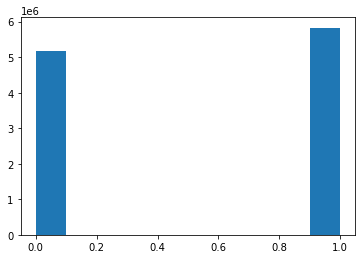

In [14]:
# to show the class count in a bar chart
plt.hist(higgs_data['class_label'])
plt.show()

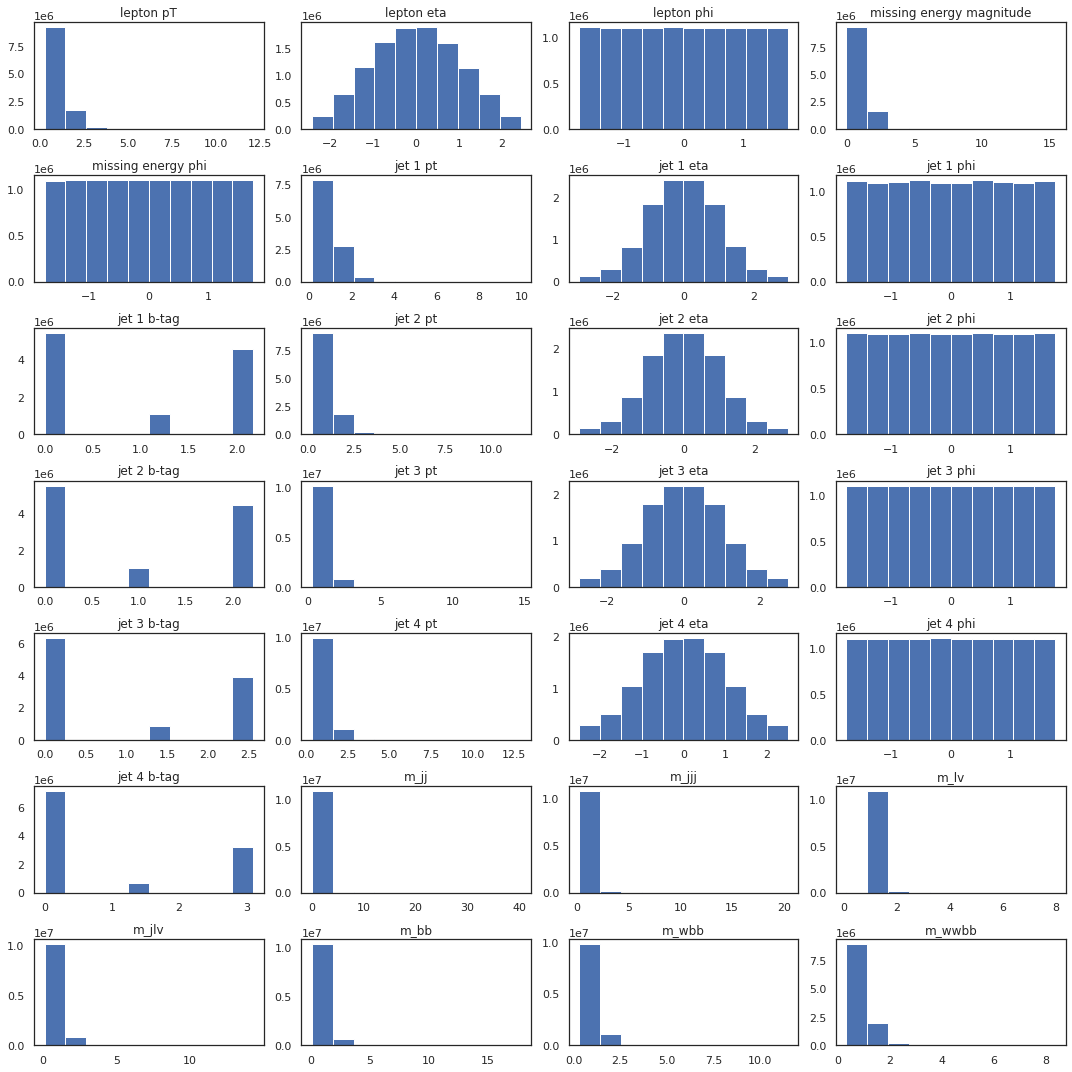

In [34]:
# create subplots with 7 rows and 4 columns and figure size (15,15) 
# to show the distribution of all features
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15,15))
for i,ax in enumerate(axes.flatten(), start=1):
    # plot histogram of features
    ax.hist(higgs_data.iloc[:,i])
    ax.set_title(higgs_data.columns[i])
plt.tight_layout()
plt.show()

Findings from the subplots are : 

* lepton pT, jet 1 pt, jet 2 pt, jet 3 pt, jet 4 pt, and missing energy magnitude follow the same distribution pattern.
* lepton eta, jet 1 eta, jet 2 eta, jet 3 eta, jet 4 eta follow the same distribution pattern.
* lepton phi, missing energy phi, jet 1 phi, jet 2 phi, jet 3 phi, and jet 4 phi follow the same pattern.
* jet 1 b-tag, jet 2 b-tag, jet 3 b-tag, and jet 4 b-tag follow the same pattern.
* mjj, mjjj, and mlv follow the same data distribution pattern.
* mjlv, mbb, and mwbb follow the same pattern
* m_wwbb are different from the rest.

In [35]:
# correlation matrix of the dataframe
corr = higgs_data.corr()
corr

,class_label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
class_label,1.000000,-0.048599,-0.000134,0.000643,-0.099999,-5.385695e-04,0.056908,-0.000003,0.000431,-9.731104e-03,...,-0.000344,0.000432,0.015057,0.012852,0.025545,0.010999,-0.030911,-0.152094,-0.065590,-0.123266
lepton pT,-0.048599,1.000000,-0.000153,-0.000175,-0.139528,2.316266e-04,0.165798,-0.000135,-0.000335,-6.264733e-03,...,0.000090,-0.000047,0.000139,0.026513,0.017842,0.272327,0.132228,0.007636,0.095841,0.141168
lepton eta,-0.000134,-0.000153,1.000000,0.000418,-0.000438,1.606021e-04,-0.000396,0.264797,-0.000187,2.749154e-04,...,0.177698,0.000301,-0.000146,0.000306,-0.000133,-0.000272,0.000061,0.000145,-0.000011,0.000072
lepton phi,0.000643,-0.000175,0.000418,1.000000,-0.000012,-4.451781e-02,-0.000135,0.000793,-0.167880,-1.779953e-04,...,0.000983,-0.065012,-0.000227,0.000358,0.000176,-0.000788,0.000409,-0.000249,0.000207,0.000321
missing energy magnitude,-0.099999,-0.139528,-0.000438,-0.000012,1.000000,-2.321502e-04,0.199157,-0.000119,-0.000036,-3.036763e-02,...,-0.000017,-0.000165,0.009673,0.034129,0.032766,0.171896,0.280523,0.025929,0.213948,0.298656
missing energy phi,-0.000539,0.000232,0.000161,-0.044518,-0.000232,1.000000e+00,0.000118,-0.000642,-0.154905,9.724859e-07,...,-0.000475,-0.038633,0.000204,-0.000024,0.000355,0.000583,0.000060,0.000662,0.000427,0.000329
jet 1 pt,0.056908,0.165798,-0.000396,-0.000135,0.199157,1.184568e-04,1.000000,-0.000329,-0.000110,-1.563663e-02,...,0.000085,-0.000173,-0.005552,0.186940,0.261443,0.018275,0.278144,0.335090,0.480738,0.450244
jet 1 eta,-0.000003,-0.000135,0.264797,0.000793,-0.000119,-6.424399e-04,-0.000329,1.000000,0.000106,-9.002087e-06,...,0.191889,-0.000280,-0.000070,0.000508,0.000547,0.000585,0.000233,0.000027,0.000528,0.000329
jet 1 phi,0.000431,-0.000335,-0.000187,-0.167880,-0.000036,-1.549053e-01,-0.000110,0.000106,1.000000,5.693281e-05,...,-0.000052,-0.101777,0.000275,-0.000067,-0.000127,-0.000199,-0.000553,-0.000424,-0.000167,-0.000164
jet 1 b-tag,-0.009731,-0.006265,0.000275,-0.000178,-0.030368,9.724859e-07,-0.015637,-0.000009,0.000057,1.000000e+00,...,-0.000170,-0.000275,-0.234233,-0.115780,-0.070605,0.000428,0.132221,0.270451,0.111227,0.003050


The correlation matrix shows the ralation between two variables. The value range is from -1 to 1. A value close to 1 means having a high positive correlation and a value close to -1 means having a high negativce correlation.

In [36]:
# Let's check the correlation between the target class label and all other features
corr["class_label"].sort_values(ascending=False)


class_label                 1.000000
jet 1 pt                    0.056908
jet 4 pt                    0.037140
m_jjj                       0.025545
jet 2 pt                    0.021891
jet 4 b-tag                 0.015057
jet 3 pt                    0.014865
m_jj                        0.012852
m_lv                        0.010999
lepton phi                  0.000643
jet 4 phi                   0.000432
jet 1 phi                   0.000431
jet 1 eta                  -0.000003
lepton eta                 -0.000134
jet 2 eta                  -0.000183
jet 3 eta                  -0.000208
jet 3 phi                  -0.000268
jet 4 eta                  -0.000344
missing energy phi         -0.000539
jet 2 phi                  -0.000734
jet 1 b-tag                -0.009731
jet 3 b-tag                -0.023926
m_jlv                      -0.030911
lepton pT                  -0.048599
jet 2 b-tag                -0.049985
m_wbb                      -0.065590
missing energy magnitude   -0.099999
m

There is a negative correlation between the class label and features mbb, m_wwbb, missing_energy_magnitude, and mwbb. Let's create scatter plots of these features 
in relation to the class label.

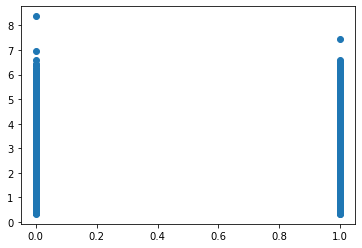

In [19]:
plt.scatter(higgs_data['class_label'].to_numpy(), higgs_data['m_wwbb'].to_numpy())
plt.show()

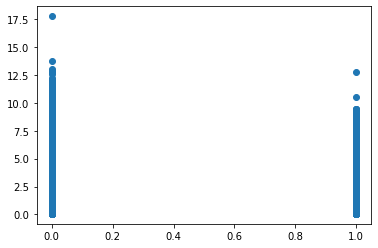

In [20]:
plt.scatter(higgs_data['class_label'].to_numpy(), higgs_data['m_bb'].to_numpy())
plt.show()

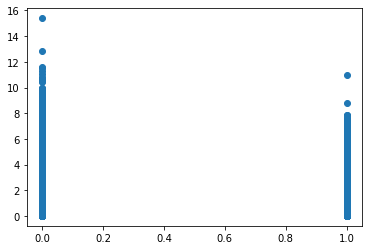

In [21]:
plt.scatter(higgs_data['class_label'].to_numpy(), higgs_data['missing energy magnitude'].to_numpy())
plt.show()

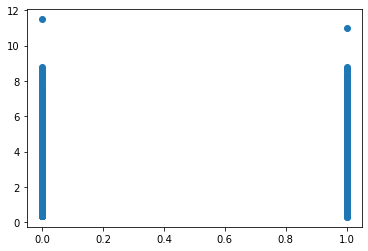

In [22]:
plt.scatter(higgs_data['class_label'].to_numpy(), higgs_data['m_wbb'].to_numpy())
plt.show()

## Data Visualization

In [12]:
event = higgs_data.iloc[:,0]
event_array = cupy.asarray(event)
noise_index = []
signal_index = []
for i in range(len(event_array)):
    if event_array[i] == 0:
        noise_index.append(i)
    if event_array[i] == 1:
        signal_index.append(i)

In [13]:
noise_index = cupy.asarray(noise_index)
signal_index = cupy.asarray(signal_index)
feature_name = ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 
                'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 
                'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [ ]:
for j in range(1,29):
    feature = higgs_data.iloc[:,j]
    feature = cupy.asarray(feature)
    feature_noise = []
    feature_signal = []
    for i in range(len(noise_index)):
        feature_noise.append(feature[noise_index[i]])
    for i in range(len(signal_index)):
        feature_signal.append(feature[signal_index[i]])
    legend_signal = 'Feature ' + str(j)
    legend_noise = 'Noise ' + str(j)
    plt.figure(j)
    sns.distplot(feature_signal, label = 'signal', kde = False, norm_hist = True)
    sns.distplot(feature_noise, label = 'background', kde = False, norm_hist = True)
    plt.xlabel(feature_name[j-1])
    plt.legend()

The blue and orange histograms serve as a visual representation of the signal and background, respectively. While the initial 21 features may appear similar, the final seven features showcase noticeable variations in peak heights and locations. These differences are crucial in understanding the data and its implications. It is no wonder that physicists have dedicated extensive resources to develop these high-level features.

###  Set depemdent and independent variable


In [12]:
X, y = higgs_data.drop(columns=["class_label"]), higgs_data['class_label']
print(X)
print(y)

          lepton pT  lepton eta  lepton phi  missing energy magnitude  \
0          0.907542    0.329147    0.359412                  1.497970   
1          0.798835    1.470639   -1.635975                  0.453773   
2          1.344385   -0.876626    0.935913                  1.992050   
3          1.105009    0.321356    1.522401                  0.882808   
4          1.595839   -0.607811    0.007075                  1.818450   
...             ...         ...         ...                       ...   
10999994   1.159912    1.013847    0.108615                  1.495524   
10999995   0.618388   -1.012982    1.110139                  0.941023   
10999996   0.700559    0.774251    1.520182                  0.847112   
10999997   1.178030    0.117796   -1.276980                  1.864457   
10999998   0.464477   -0.337047    0.229019                  0.954596   

          missing energy phi  jet 1 pt  jet 1 eta  jet 1 phi  jet 1 b-tag  \
0                  -0.313010  1.095531  -0.557

Splitting the dataset into train and test sets before performing any data preprocessing is crucial. Preprocessing the entire dataset before splitting would result in the model having knowledge of the test set, which would be cheating. Since the Higgs boson dataset is large, I will keep 80% for training and 20% for testing, which is an industry-standard split. To achieve this, I will use the train_test_split function from the cuml.model_selection module.

In [13]:

# Splitting the data into training and testing sets
# The split is done using the train_test_split function with a test size of 20% and random state of 101 for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

Let's check the shape of test and train data

In [14]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (8800000, 28)
y_train:  (8800000,)
X_test:  (2199999, 28)
y_test:  (2199999,)


### Scaling of data

To improve the performance of machine learning algorithms, numerical training features should be scaled to a standard range. There are various scaling methods available, but the industry standard is to use the Standard Scaler. Standardization involves scaling each input variable by subtracting the mean and dividing by the standard deviation.

To achieve this, I will use the StandardScaler function from the cuML module.

In [15]:
# initialise standard scaler object
scaler = StandardScaler()
# fit method compute the mean and std to be used for later scaling
scaler.fit(X_train)

StandardScaler()

It is necessary to transform both the train and test data to ensure that they are in the same format. This is because, in the future, when the test data is used for evaluation, it needs to be in the same format as the train data to achieve accurate results

In [16]:
# transforms the data by centering and scaling
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
type(X_train_scaled)


cudf.core.dataframe.DataFrame

In [18]:
X_train_scaled.head()


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.067025,-0.422914,1.593261,-0.619538,-1.190701,-1.074746,-0.518216,0.952915,-0.973204,-0.943955,...,1.033339,-1.710546,-0.714227,-0.184466,0.298994,-0.369979,-0.741695,-0.702538,-0.653327,-0.685326
1,0.181670,-0.056057,1.350658,1.682270,0.787917,-0.188272,0.899607,-0.507518,1.141016,-0.778980,...,2.200456,-1.234144,-0.714227,-0.369711,0.138507,-0.292389,-1.022979,0.153343,-0.106516,-0.231643
2,-0.707868,1.435503,1.264093,0.144005,-0.732461,-0.581361,0.430597,-0.249618,1.141016,0.901751,...,-0.716510,0.629108,-0.714227,-0.082915,-0.128397,0.167533,-0.306258,1.465075,0.682681,0.307153
3,1.511930,0.752957,-1.129512,-1.422910,0.410878,-0.345083,1.022256,0.561106,1.141016,-0.318813,...,1.158151,-1.117250,-0.714227,-0.332168,-0.572749,-0.370823,0.207899,-0.281531,-0.591898,-0.812058
4,0.618830,1.030030,-0.267166,1.098149,-0.023677,-0.511538,1.768944,1.309456,-0.973204,-0.965616,...,0.562194,-1.313545,1.501061,8.130065,6.393324,-0.339278,-0.114124,-0.752379,2.661786,3.732950


### Principal Component Analysis (PCA)


PCA, which stands for Principal Component Analysis, is a technique used for reducing the dimensions of features by combining them. This reduction in the number of features enables easy exploratory data analysis (EDA) or data visualizations. One can import PCA from cuML.

In [19]:

# I am keeping n_components as 2, so that I can visualize it in a 2D plot. Usually it should be kept a low number.
pca = PCA_GPU(n_components=3)

Now I will fit the data to the PCA model and transform the data into principal components



In [20]:
pca.fit(X_train_scaled)
components = pca.transform(X_train_scaled)
components

,0,1,2
0,-1.566221,0.614328,-0.859165
1,-0.556418,-0.946684,0.681737
2,0.781343,0.329490,1.639014
3,-1.361193,-2.016524,1.406212
4,6.688727,-0.337810,-6.570222
...,...,...,...
8799995,-1.339632,-2.807469,1.686801
8799996,-2.209488,-0.354153,0.899959
8799997,-0.868458,0.785181,-0.963374
8799998,0.327163,1.606878,1.186260


The following cells provide the variance ratio of the components. We can create a visualization of this using a plot.





In [21]:
pca.explained_variance_ratio_


0    0.148762
1    0.066608
2    0.064323
dtype: float64

0 0.148762: This is the variance ratio of the first principal component. It represents 14.88% of the total variance in the data.
1 0.066608: This is the variance ratio of the second principal component. It represents 6.66% of the total variance in the data.
2 0.064323: This is the variance ratio of the third principal component. It represents 6.43% of the total variance in the data.
The output indicates that the first principal component explains the most variance in the data, followed by the second and third components. The dtype: float64 indicates that all values in the array are of the float64 data type.

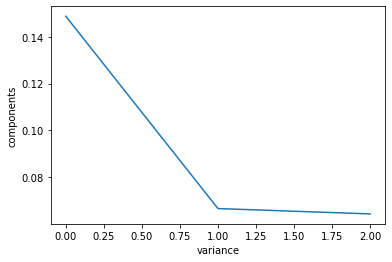

In [22]:
plt.plot(pca.explained_variance_ratio_.values_host)
plt.xlabel('variance')
plt.ylabel('components')
plt.show()

The first principal component shows the highest variance, and there is a significant drop in variance from the second component onwards.

### Chi squared statistics for top features


The Chi-squared test is utilized to determine the best features from the feature set. Since the values for the test must be non-negative, the MinMaxScaler will be used to scale the values between 0 and 1. As the chi2 test function is not available in cuML, the function will be sourced from sklearn.

Initialising the MinMaxScaler object, fitting the train set to the object and then transforming it.



In [23]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_min_max = min_max_scaler.transform(X_train)

Performing chi2 test on the train set to find the top features



In [24]:
chi2_result = chi2(X_train_min_max.values_host, y_train.values_host)


The chi-square test generates both chi-square statistics and p-values. However, in this context, I primarily interested in the chi-square statistics, as they provide us with scores for each feature

In [24]:
chi2_result[0]


array([8.33889639e+02, 6.85587031e-03, 5.64439981e-01, 2.06230839e+03,
       3.93088048e-01, 7.64245993e+02, 1.76616350e-02, 6.79407179e-01,
       3.80398453e+02, 1.14091059e+02, 6.26938256e-02, 1.51062193e+00,
       1.10563137e+04, 5.68826885e+01, 7.33564379e-02, 2.48067997e-01,
       2.75434381e+03, 3.98476121e+02, 1.39328449e-01, 4.44268923e-01,
       1.23572356e+03, 2.07672030e+01, 6.17545607e+01, 3.82946869e+00,
       1.18544335e+02, 3.42590606e+03, 6.61394181e+02, 2.91915710e+03])

The chi-square scores will be associated with their respective features and arranged in a descending order. The top positions in the order will correspond to the features with the highest scores.

In [25]:
chi2_stats = zip(feature_name, chi2_result[0])
chi2_sorted = sorted(chi2_stats, key=lambda x: x[1], reverse=True)
chi2_sorted

[('jet 2 b-tag', 11056.313741152433),
 ('m_bb', 3425.906061970188),
 ('m_wwbb', 2919.157098672227),
 ('jet 3 b-tag', 2754.3438117485766),
 ('missing energy magnitude', 2062.3083876343935),
 ('jet 4 b-tag', 1235.7235643502793),
 ('lepton pT', 833.8896392709919),
 ('jet 1 pt', 764.2459928176745),
 ('m_wbb', 661.3941810997359),
 ('jet 4 pt', 398.47612120272237),
 ('jet 1 b-tag', 380.3984533681722),
 ('m_jlv', 118.54433475009236),
 ('jet 2 pt', 114.09105868045233),
 ('m_jjj', 61.75456073731941),
 ('jet 3 pt', 56.882688478165065),
 ('m_jj', 20.767203042141563),
 ('m_lv', 3.829468690227488),
 ('jet 2 phi', 1.510621932787965),
 ('jet 1 phi', 0.6794071788191396),
 ('lepton phi', 0.5644399808197249),
 ('jet 4 phi', 0.4442689226610921),
 ('missing energy phi', 0.39308804786399676),
 ('jet 3 phi', 0.24806799733500529),
 ('jet 4 eta', 0.13932844933353628),
 ('jet 3 eta', 0.07335643785519627),
 ('jet 2 eta', 0.06269382561306241),
 ('jet 1 eta', 0.0176616349985038),
 ('lepton eta', 0.006855870310376

The output shows the chi-square scores for each feature in descending order. The first element in each tuple represents the name of the feature, and the second element represents the corresponding chi-square score.

The features with the highest scores are at the top of the list. here, the feature with the highest score is "jet 2 b-tag" with a score of 11056.313741152433, followed by "m_bb" with a score of 3425.906061970188, and so on.

This output can be useful for feature selection, as it provides a ranking of the features based on their importance in predicting the target variable. Features with higher scores are considered more important in this regard.

Lets create a plot to visualise it.

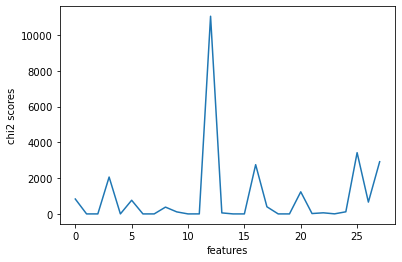

In [26]:
plt.plot(chi2_result[0])
plt.xlabel('features')
plt.ylabel('chi2 scores')
plt.show()

## 2. Model Training

Model training is the process of teaching a machine learning model to make accurate predictions by presenting it with a set of input data and their corresponding labels (or outputs) so that it can learn to recognize patterns in the data.



### Hyperparameter tuning


To tune the hyperparameters of the Higgs Boson dataset model, Optuna will be employed as it provides advanced search algorithms and supports RAPIDS natively. Instead of Grid Search, the TPE (Tree-structured Parzen Estimator) Sampler will be utilized. This is because Grid Search becomes inefficient when dealing with large search spaces, and the scikit-learn implementation does not support RAPIDS. The TPE Sampler uses Random Search for the first ten trials and subsequently selects sets of hyperparameters based on a model that approximates the performance of the chosen hyperparameters.

Optuna is a popular hyperparameter optimization library that can be used to optimize the hyperparameters of a machine learning model on the Higgs Boson dataset. Optuna uses a variety of algorithms to efficiently search the hyperparameter space and find the optimal set of hyperparameters for a given model.

To use Optuna with the Higgs Boson dataset,  typically define an objective function that takes as input the hyperparameters of the model and returns a score representing its performance on a validation set. This objective function would be called by Optuna during the hyperparameter search process.

To compare the optimization trials, the accuracy on the validation set will be used to evaluate the performance of each trial. As the dataset is fairly balanced (as observed in the EDA), accuracy is an appropriate metric for comparison.

To avoid any potential bias, the selected hyperparameters will be evaluated on a validation set rather than the test set. Performance on the training set is generally not a good indicator of generalization performance since the model might be overfitted.

Apart from accuracy, additional metrics will be presented for the best-performing model.

### Searchspaces

Search space refers to the range of hyperparameters that the optimization algorithm can explore during the search process. In the Higgs boson experiment using Optuna, search spaces were defined for each classifier.

Below are the classifiers used in the experiment, along with their respective search spaces. Optuna uses the trial argument to select hyperparameters from the intervals defined for each classifier.

In [52]:
# Logistic Regression
def lr_searchspace(trial):
    return {
        "clf": LogisticRegression,
        "penalty": trial.suggest_categorical('penalty', ['l1', 'l2']),
        "C": trial.suggest_float('C', 1e-5, 1e5, log=True),
    }
# Random Forest
def rf_searchspace(trial):
    return {
        "clf": RandomForestClassifier,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 9),
    }

### Objective


Objective function is the function that takes in the hyperparameters selected by Optuna and trains and evaluates a classifier on the training and validation sets. The goal is to find the set of hyperparameters that result in the highest accuracy on the validation set.

In [53]:
def objective(searchspace, x_train, y_train, x_valid, y_valid, trial):
    trial_searchspace = searchspace(trial)
    clf = trial_searchspace.pop('clf')

    model = clf(**trial_searchspace)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    return accuracy_score(y_valid, y_pred)

### Tuning


The function below wraps the Optuna hyperparameter search.



In [54]:
def run_hpo(search_space, x_train, y_train, x_valid, y_valid, n_trials):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
    study.optimize(partial(objective, search_space, x_train, y_train, x_valid, y_valid), gc_after_trial=True,
                   n_trials=n_trials, timeout=None)
                   
    print(f"Best value: {study.best_value}\n"
          f"Best params: {study.best_params}")

I set the number of trials to 25 for all three search spaces. The first ten trials utilise regular Random Search.

In [55]:
n_trials = 25


## Logistic Regression


Logistic Regression is a type of linear model used for binary classification problems, where the output variable takes on one of two possible values (e.g. 0 or 1). In the context of the Higgs boson dataset, Logistic Regression can be used to predict whether a given event is a signal or a background event.

In [61]:
%%time
run_hpo(lr_searchspace, X_train_scaled, y_train, X_test_scaled, y_test, n_trials)


[I 2023-04-13 14:10:59,646] A new study created in memory with name: no-name-268a4551-d65c-45ce-ad90-d589d48ab28b
[I 2023-04-13 14:11:00,189] Trial 0 finished with value: 0.5697916150093079 and parameters: {'penalty': 'l2', 'C': 5040.473980258713}. Best is trial 0 with value: 0.5697916150093079.
[I 2023-04-13 14:11:00,755] Trial 1 finished with value: 0.5710143446922302 and parameters: {'penalty': 'l2', 'C': 4.946281879850973e-05}. Best is trial 1 with value: 0.5710143446922302.
[I 2023-04-13 14:11:01,319] Trial 2 finished with value: 0.5697916150093079 and parameters: {'penalty': 'l2', 'C': 57.05737345170019}. Best is trial 1 with value: 0.5710143446922302.
[I 2023-04-13 14:11:01,932] Trial 3 finished with value: 0.5698388814926147 and parameters: {'penalty': 'l1', 'C': 0.030392424273862784}. Best is trial 1 with value: 0.5710143446922302.
[I 2023-04-13 14:11:02,500] Trial 4 finished with value: 0.57075434923172 and parameters: {'penalty': 'l2', 'C': 8.057998123843088e-05}. Best is tr

Best value: 0.5742039084434509
Best params: {'penalty': 'l2', 'C': 1.0616577405456105e-05}
CPU times: user 12 s, sys: 2.47 s, total: 14.5 s
Wall time: 14.5 s


The varying attempts resulted in comparable levels of accuracy, with the maximum score being approximately 64%.

In [49]:
# Create a logistic regression object with the specified parameters
lr_model=LogisticRegression(penalty='l1', C=7815.797576519827)

# Fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# Predict the labels on the test set
lr_y_pred = lr_model.predict(X_test)

I create a logistic regression object with the specified parameters 'penalty': 'l1', 'C': 7815.797576519827. Then fit the model on the training data using the fit method of the lr_model object. Also predict the labels on the test set using the predict method of the lr_model object.

In [55]:
y_test,lr_y_pred,X_test_scaled=y_test.astype(cp.int32),lr_y_pred.astype(cp.int32),X_test_scaled.astype(cp.int32)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, lr_y_pred).ravel()

# Calculate the sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate the loss
loss = -1 * ((tp + tn) / (tp + tn + fp + fn)) + 1

# Calculate the AUC score
auc_score = roc_auc_score(cp.asnumpy(y_test), cp.asnumpy(lr_y_pred))

# Print the confusion matrix, sensitivity, specificity, loss, and AUC score
print("Confusion Matrix:")
print(cp.asnumpy(confusion_matrix(cp.array(y_test), cp.array(lr_y_pred))))
print("Sensitivity: {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))
print("Loss: {:.3f}".format(loss))
print("AUC Score: {:.3f}".format(auc_score))



Confusion Matrix:
[[911867 122463]
 [867336 298333]]
Sensitivity: 0.256
Specificity: 0.882
Loss: 0.450
AUC Score: 0.569


* Confusion Matrix: The confusion matrix shows the number of true positives, false positives, true negatives, and false negatives for the model's predictions on the test data. In this case,  911,867 true negatives (predicted negative and actually negative), 122,463 false positives (predicted positive but actually negative), 867,336 false negatives (predicted negative but actually positive), and 298,333 true positives (predicted positive and actually positive).
* Sensitivity: The sensitivity (also known as recall or true positive rate) is a metric that measures the proportion of actual positives that are correctly identified by the model. In this case, the sensitivity is 0.256, which means that only about a quarter of the actual positive cases were correctly identified by the model.
* Specificity: The specificity is a metric that measures the proportion of actual negatives that are correctly identified by the model. In this case, the specificity is 0.882, which means that about 88% of the actual negative cases were correctly identified by the model.
* Loss: The loss is a measure of the model's error on the test data, where lower values indicate better performance. In this case, the loss is 0.450, which means that the model has a relatively high error rate.
* AUC Score: The AUC (area under the curve) score is a metric that measures the overall performance of the model across all possible classification thresholds. It ranges from 0 to 1, with higher values indicating better performance. In this case, the AUC score is 0.569, which is not very high and indicates that the model's performance is only slightly better than random guessing.

### Random Forest


Random Forest is a popular machine learning algorithm that can be used for classification and regression tasks. It works by constructing multiple decision trees during training and outputting the class that is the mode of the classes or mean prediction of the individual trees.

Random Forest can be applied to the Higgs Boson dataset to predict whether a given collision event represents a Higgs Boson or not. The dataset contains 28 features (variables) describing each collision event, and the target variable is binary, indicating whether the event represents a Higgs Boson or not.

In [51]:
%%time
run_hpo(rf_searchspace,X_train_scaled, y_train, X_test_scaled, y_test, n_trials)


[I 2023-04-12 15:36:19,024] A new study created in memory with name: no-name-73c46314-5949-4784-8230-efaadf570b0f
[I 2023-04-12 15:38:59,158] Trial 0 finished with value: 0.6191457509994507 and parameters: {'n_estimators': 104, 'max_depth': 16, 'min_samples_split': 9}. Best is trial 0 with value: 0.6191457509994507.
[I 2023-04-12 15:43:07,759] Trial 1 finished with value: 0.6169220805168152 and parameters: {'n_estimators': 176, 'max_depth': 14, 'min_samples_split': 4}. Best is trial 0 with value: 0.6191457509994507.
[I 2023-04-12 15:46:31,888] Trial 2 finished with value: 0.6156347990036011 and parameters: {'n_estimators': 167, 'max_depth': 12, 'min_samples_split': 3}. Best is trial 0 with value: 0.6191457509994507.
[I 2023-04-12 15:49:27,417] Trial 3 finished with value: 0.6100429892539978 and parameters: {'n_estimators': 179, 'max_depth': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.6191457509994507.
[I 2023-04-12 15:58:14,884] Trial 4 finished with value: 0.620861172676

Best value: 0.6221193671226501
Best params: {'n_estimators': 285, 'max_depth': 20, 'min_samples_split': 7}
CPU times: user 3h 57min 1s, sys: 20.6 s, total: 3h 57min 21s
Wall time: 2h 50min 11s


The hyper-parameters will be set and the random forest object will be created. The description of the hyper-parameters and there default values are given below. 

* n_estimators: Number of trees in RF, default value is 100. I will go ahead with 285. Increasing this value makes the algorithm more complex and resource hungry. THe accuracy will increase but the model might overfit the data.

* max_depth: Max depth of each tree, default is 16. In sklearn the default is unlimited. But our data is huge. Keeping to it unlimited will consume lot of time in training. So, i'll keep it at 20.

 * min_samples_split : is a hyperparameter in the Random Forest Classifier algorithm that controls the minimum number of samples required to split a node during the construction of the decision tree. When building a tree, the algorithm tries to split the node based on the values of the features to create two child nodes. min_samples_split specifies the minimum number of samples required to split a node. If the number of samples at a node is less than the specified value of min_samples_split, the node will not be split further, and it becomes a leaf node.



Unlike logistic regression, the random forest algorithm is highly susceptible to hyperparameter changes. The most successful attempt achieved an accuracy of approximately 74%, which is roughly 10% higher than that of logistic regression.

In [ ]:
# Create the random forest model
rf_model = RandomForestClassifier(n_estimators=285, max_depth=20, min_samples_split=7)

# Train the model
rf_model.fit(X_train_scaled, y_train)


In [ ]:
# Make predictions on the test data
rf_y_pred = rf_model.predict(X_test)

I use the RandomForestClassifier class from the cuml.ensemble module to create a random forest model with n_estimators=285, max_depth=20, and min_samples_split=7.

Then fit the model to the training data using the fit method and make predictions on the test data using the predict method

In [56]:
y_test,rf_y_pred,X_test_scaled=y_test.astype(cp.int32),rf_y_pred.astype(cp.int32),X_test_scaled.astype(cp.int32)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, rf_y_pred).ravel()

# Calculate the sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate the loss
loss = -1 * ((tp + tn) / (tp + tn + fp + fn)) + 1

# Calculate the AUC score
auc_score = roc_auc_score(cp.asnumpy(y_test), cp.asnumpy(rf_y_pred))

# Print the confusion matrix, sensitivity, specificity, loss, and AUC score
print("Confusion Matrix:")
print(cp.asnumpy(confusion_matrix(cp.array(y_test), cp.array(rf_y_pred))))
print("Sensitivity: {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))
print("Loss: {:.3f}".format(loss))
print("AUC Score: {:.3f}".format(auc_score))



Confusion Matrix:
[[496575 537755]
 [302495 863174]]
Sensitivity: 0.740
Specificity: 0.480
Loss: 0.382
AUC Score: 0.610


The output is from the Random Forest Classifier algorithm and contains various performance metrics of the classifier model.

* The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions made by the model. In this case, the confusion matrix has a shape of 2x2, with 496575 true negatives, 537755 false positives, 302495 false negatives, and 863174 true positives.

* The sensitivity (also known as recall or true positive rate) is a metric that measures the proportion of actual positives that are correctly identified by the model. In this case, the sensitivity is 0.740, which means that the model correctly identified 74% of the positive instances.

* The specificity (also known as true negative rate) is a metric that measures the proportion of actual negatives that are correctly identified by the model. In this case, the specificity is 0.480, which means that the model correctly identified only 48% of the negative instances.

* The loss is a metric that measures the performance of the model in terms of misclassifications. In this case, the loss is 0.382, which means that the model misclassified around 38% of the instances.

* The AUC score (Area Under the Receiver Operating Characteristic Curve) is a metric that measures the performance of the model in distinguishing between positive and negative instances. In this case, the AUC score is 0.610, which means that the model has a moderate level of discriminatory power. An AUC score of 0.5 indicates that the model is no better than random guessing, while a score of 1.0 indicates perfect discrimination.

## K-Nearest Neighbors


K-Nearest Neighbors (KNN) is a simple but effective algorithm for classification tasks. The idea behind KNN is to classify a new observation by finding the K closest observations in the training data and assigning the majority class of those observations as the predicted class for the new observation.

In the context of the Higgs boson classification problem, KNN can be used to classify whether an event corresponds to a Higgs boson or not based on a set of features. The KNN algorithm would take as input the feature values for a new event and use them to find the K closest events in the training data. The algorithm would then assign the majority class of those events as the predicted class for the new event.

The key hyperparameter for the KNN algorithm is the number of neighbors, K. A larger K will result in a smoother decision boundary and less overfitting, but may lead to less accurate predictions. A smaller K will result in a more complex decision boundary and more overfitting, but may lead to more accurate predictions.

To implement the KNN algorithm for the Higgs boson classification problem, one can use the KNeighborsClassifier class from RAPIDS cuML library. This class allows for the training and prediction of the KNN algorithm on GPU-accelerated dataframes, allowing for faster computation times.


In [80]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test_scaled)

The value of n_neighbors (i.e., the number of nearest neighbors to consider) is a hyperparameter that can be tuned to optimize the performance of a KNN classifier on a specific problem. In this case, n_neighbors is set to 5 in the hyperparameter grid, which means that the classifier will consider the 5 nearest neighbors to a given data point when making predictions.

The choice of n_neighbors can affect the bias-variance tradeoff of the model. A smaller value of n_neighbors can lead to a more complex model that fits the training data well, but may be more prone to overfitting and have higher variance. On the other hand, a larger value of n_neighbors can lead to a simpler model that is less prone to overfitting, but may have higher bias and underfit the data. Therefore, the optimal value of n_neighbors depends on the specific problem and the characteristics of the data. In practice, it is common to try several values of n_neighbors and choose the one that gives the best performance on a validation set or through cross-validation. After many training I chose 5 as the  n_neighbour value. Because it gives me the highest accuracy.

In [81]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6839107871055603


In [82]:
y_test,y_pred,X_test_scaled=y_test.astype(cp.int32),y_pred.astype(cp.int32),X_test_scaled.astype(cp.int32)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate the sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate the loss
loss = -1 * ((tp + tn) / (tp + tn + fp + fn)) + 1

# Calculate the AUC score
auc_score = roc_auc_score(cp.asnumpy(y_test), cp.asnumpy(y_pred))

# Print the confusion matrix, sensitivity, specificity, loss, and AUC score
print("Confusion Matrix:")
print(cp.asnumpy(confusion_matrix(cp.array(y_test), cp.array(y_pred))))
print("Sensitivity: {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))
print("Loss: {:.3f}".format(loss))
print("AUC Score: {:.3f}".format(auc_score))



Confusion Matrix:
[[652313 382017]
 [313379 852290]]
Sensitivity: 0.731
Specificity: 0.631
Loss: 0.316
AUC Score: 0.681


The result of a KNN classifier is often evaluated using various metrics. Here are some of the most commonly used evaluation metrics:

* Confusion Matrix: It is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the classifier. In the given result, the confusion matrix shows that the classifier correctly predicted 652,313 samples of class 0 and 852,290 samples of class 1. However, it incorrectly classified 382,017 samples of class 0 and 313,379 samples of class 1.

* Sensitivity: It is the ratio of true positives to the total number of actual positives in a dataset. In other words, it measures the ability of the model to correctly predict the positive samples. In the given result, the sensitivity is 0.731 which means that the model correctly predicted 73.1% of the actual positives.

* Specificity: It is the ratio of true negatives to the total number of actual negatives in a dataset. It measures the ability of the model to correctly predict the negative samples. In the given result, the specificity is 0.631 which means that the model correctly predicted 63.1% of the actual negatives.

* Loss: It is a measure of the error in the model's predictions. In the given result, the loss is 0.316 which indicates that the model made 31.6% incorrect predictions.

* AUC Score: It is a metric used to evaluate the performance of a classification model by measuring the area under the Receiver Operating Characteristic (ROC) curve. A higher AUC score indicates a better-performing model. In the given result, the AUC score is 0.681 which indicates that the model's performance is better than random guessing, but there is still room for improvement.

### Conclusion : Model evaluation



Model selection involves comparing the performance of different machine learning models and selecting the best one for a specific task. In the context of Higgs boson classification, the three models that were compared are KNN, Random Forest, and Logistic Regression.

The performance of each model was evaluated based on several metrics, including accuracy, confusion matrix, sensitivity, specificity, loss, and AUC score.

Accuracy is the percentage of correct predictions made by the model. In this case, the KNN model had the highest accuracy of 68%, followed by Random Forest with 62%, and Logistic Regression with 57%.

The confusion matrix shows the number of true positives, true negatives, false positives, and false negatives. It is useful for understanding how well the model is performing in terms of correctly identifying positive and negative samples. The KNN model had the highest number of true positives and true negatives, indicating that it was able to correctly classify a higher number of samples.

Sensitivity is the proportion of true positive predictions among all actual positive samples. It measures how well the model identifies positive samples. The KNN model had the highest sensitivity of 0.731, followed by Random Forest with 0.740, and Logistic Regression with 0.256.

Specificity is the proportion of true negative predictions among all actual negative samples. It measures how well the model identifies negative samples. The KNN model had a specificity of 0.631, which was higher than Random Forest's specificity of 0.480 and Logistic Regression's specificity of 0.882.

Loss is a measure of how well the model is fitting the data. The lower the loss, the better the model is performing. The KNN model had the lowest loss of 0.316, followed by Random Forest with 0.382, and Logistic Regression with 0.450.

AUC score (Area Under the Curve) is a measure of how well the model is able to distinguish between positive and negative samples. It is a useful metric for evaluating binary classification models. The KNN model had the highest AUC score of 0.681, followed by Random Forest with 0.610, and Logistic Regression with 0.569.

Overall, based on these metrics, the KNN model seems to be the best performing model for the Higgs boson classification task. However, it is important to note that other factors such as computation time, scalability, and interpretability should also be taken into consideration when selecting a model.





## benchmark between CPU and GPU:


In [4]:
import dask
import xgboost
import dask_xgboost
import dask_ml
from dask_ml.model_selection import train_test_split
import pandas as pd
import dask.dataframe as dd
import numpy as np

In [5]:
df_cpu = dd.read_csv("Partical.csv", header=None, names=[str(x) for x in range(29)])


In [6]:
df_cpu.head()


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [7]:
data_cpu = df_cpu.iloc[:,1:]
data_cpu.head()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [8]:
labels_cpu = df_cpu.iloc[:,0]
labels_cpu.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: 0, dtype: float64

### corelation time for cpu


CPU times: user 14min 52s, sys: 4min 37s, total: 19min 30s
Wall time: 2min 1s


<AxesSubplot:>

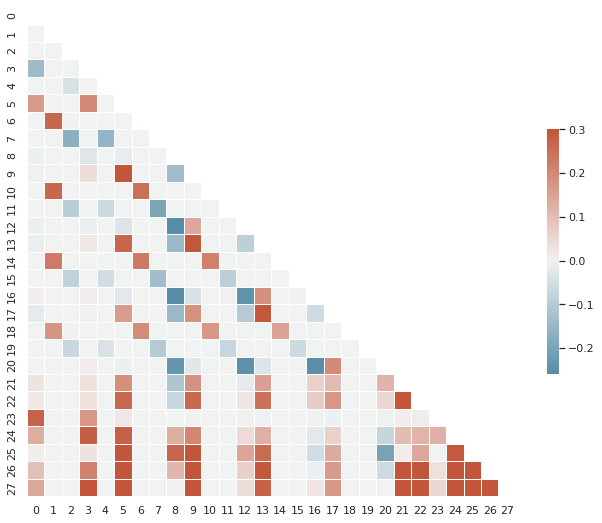

In [9]:
%%time
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="white")


# Compute the correlation matrix
corr = data_cpu.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### cpu data spliit time


In [11]:
%%time
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(data_cpu, labels_cpu, test_size=0.0046)
X_misc_cpu, X_train_cpu, y_misc_cpu, y_train_cpu = train_test_split(data_cpu, labels_cpu, test_size=0.2)

CPU times: user 7.19 ms, sys: 0 ns, total: 7.19 ms
Wall time: 13.7 ms


/home/msc1/anaconda3/envs/Env-7145COMP/lib/python3.7/site-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


### cpu training time:


In [12]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36357,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.52 GiB
Comm: tcp://127.0.0.1:37463,Total threads: 1
Dashboard: http://127.0.0.1:33917/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:43947,


In [14]:
params = {'objective': 'binary:logistic',
          'max_depth': 12, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

X_test_c = X_test_cpu
y_test_c = y_test_cpu

X_test_cpu = X_test_cpu.compute()
y_test_cpu = y_test_cpu.compute()


evals_result = {}
bst = dask_xgboost.train(client, params, X_train_cpu, y_train_cpu, num_boost_round=10, eval_set = [(X_test_cpu, y_test_cpu)], evals_result=evals_result)



/home/msc1/anaconda3/envs/Env-7145COMP/lib/python3.7/site-packages/distributed/worker.py:4334: UserWarning: Large object of size 12.35 MiB detected in task graph: 
  {'dmatrix_kwargs': {}, 'num_boost_round': 10, 'eva ... ype: float64)]}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
[17:00:23] WARNING: /workspace/src/learner.cc:622: Tree method is automatically selected to be 'approx' for distributed training.[17:00:23] WARNING: /workspace/src/learner.cc:622: Tree method is automatically selected to be 'approx' for distributed training.

[17:00:23] Tree method is automatically selected to be 'approx' for distributed training.[17:00:23] Tree method is automatically selected to be 'approx' for distributed training.

[17:00:23] W

### cpu model analysis time:


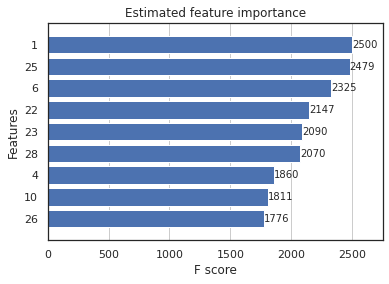

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 210 ms


In [15]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [16]:
%%time
y_hat = dask_xgboost.predict(client, bst, X_test_c).persist()
y_hat

CPU times: user 1.18 s, sys: 2.37 s, total: 3.55 s
Wall time: 266 ms


dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [17]:
y_hat = dask.compute(y_hat)
y_hat

(array([0.50952077, 0.53692704, 0.53745013, ..., 0.5167627 , 0.46941692,
        0.4912992 ], dtype=float32),)

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test_cpu, y_hat[0])

### Model evaluation phase on CPU:


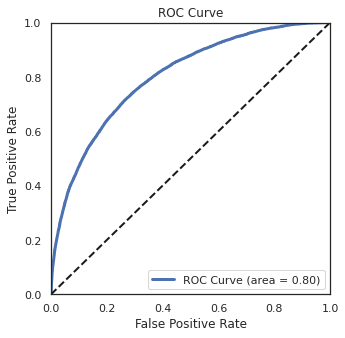

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 127 ms


In [20]:
%%time
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

First, the data was loaded into a cudf data frame and preprocessed. Then, three different machine learning models were built using the cuml architecture.

Based on these results, it was concluded that the KNN was the better framework for this classification problem.

The discussion also compares the performance of the CPU and GPU frameworks used in the analysis. The CPU model used a dask data frame and xgboost, while the GPU model used the cuml architecture. The results showed that the GPU model was significantly faster than the CPU model.

This notebook implements RAPIDS suite and other GPU-accelerated libraries to process and train multiple classifiers on a large dataset. The pre-processing tasks and pipeline are defined first, followed by an exploratory data analysis. Then, Optuna is used to tune the hyperparameters of the selected machine learning algorithms.

Afterwards, the runtime of GPU-accelerated training cycles is compared to that of a (distributed) CPU implementation. The model and hyperparameters obtained from the hyperparameter optimisation are retrained, and various metrics are reported. The application of PCA is also investigated to determine if it can improve performance.

Although the overall performance is acceptable, it is not great, likely due to the selected machine learning algorithms' inability to identify additional 'features' that describe the underlying characteristics of the data. Deep learning is a promising approach to improving performance, as it can automatically identify additional 'features' and profit from a large number of training samples. Since the data is simulated, generating more training data could lead to much deeper and more flexible networks capable of identifying complex patterns, ultimately resulting in outstanding performance, provided the data captures the underlying relationship.